In [5]:
import sys
sys.path.append('/mnt/disk01/note/workspaces/duxinxian')
import pandas as pd
import numpy as np
import os
import datetime
import scorecardpy as sc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score,train_test_split,StratifiedKFold
from sklearn.metrics import SCORERS
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from unity import feature_selector as fs
from unity.fea_eda_func import FeaEdaFunc

In [2]:
cust_main = pd.read_csv('data/sxd_cust_tag.csv')

In [3]:
cust_main['obs_dt'] = cust_main['obs_dt'].astype(str)

## 1.专家特征处理匹配

In [ ]:
edf = pd.read_excel('data/eprt_fea/sxd_zj.xlsx')

In [704]:
ind = pd.read_excel('data/eprt_fea/东方微银贷后指标.xlsx')

In [705]:
cus_busid = pd.read_csv('data/cust_busid.csv')

In [706]:
cus_busid.head()

,req_id,customerid,businessid
0,12021063017581003436,4500413770,TCL20210600002432
1,12021063017491003435,4500413879,TCL20210600002437
2,12021063016071003421,4500413413,TCL20210600002418
3,12021063013581003370,3000780287,TCL20210600002398
4,12021063017291003433,4500413822,TCL20210600002436


In [675]:
edf.head()

,businessid,WN_BNK001,WN_BNK007,WN_BNK033,WN_BNK043,warn_month,WN_ECR075,WN_ECR011,WN_ECR028,WN_ECR038,...,ICR0021,XIB017,XIB033,XIB036,XIB045,XIB024,XIB049,ICR0003,label,warn_state
0,TCL20180900000092,0,0,0,0,2018-10-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TCL20180900000092,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,TCL20180900000145,0,0,0,0,2018-11-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,TCL20180900000145,0,0,0,0,2018-12-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,TCL20180900000145,0,0,0,0,2019-01-01,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [676]:
edf['warn_month'] = edf['warn_month'].astype('datetime64[ns]')

In [4]:
cust_main['obj_date'] = pd.to_datetime(cust_main['obs_dt'], format='%Y%m%d')
cust_main['cust_no'] = cust_main['cust_no'].astype(str)
cust_main = cust_main.sort_values(['cust_no','obj_date'])

In [678]:
cus_busid = cus_busid.rename({'customerid':'cust_no'},axis=1)
cus_busid['cust_no'] = cus_busid['cust_no'].astype(str)

In [679]:
edf = cus_busid.merge(edf)
edf = edf.rename({'warn_month':'obj_date'},axis=1)
edf = edf.sort_values(['cust_no','obj_date'])
# edf['obs_dt'] = edf['obj_date'].apply(lambda x:datetime.datetime.strftime(x,'%Y%m'))

In [680]:
edf['p'] = 0
edf.loc[edf['obj_date'] <= '2019-12-31','p'] = 1
edf.loc[(edf['obj_date'] > '2019-12-31')&(edf['obj_date'] <= '2020-03-31'),'p'] = 2
edf.loc[(edf['obj_date'] > '2020-03-31')&(edf['obj_date'] <= '2020-06-30'),'p'] = 3
edf = edf[edf['p'] != 0]

In [681]:
edfp = edf.groupby(['cust_no','p']).last().reset_index()

In [682]:
cust_main['p'] = 0
cust_main.loc[cust_main['obj_date'] == '2019-12-31','p'] = 1
cust_main.loc[cust_main['obj_date'] == '2020-03-31','p'] = 2
cust_main.loc[cust_main['obj_date'] == '2020-06-30','p'] = 3

In [683]:
main_df = cust_main.merge(edfp.loc[:, ~edfp.columns.str.contains('obs_dt|obj_date')],on=['cust_no','p'],how='left')

In [684]:
# TODO:专家特征匹配缺失,cm_retail_lon_acct合同号（cont_no）与进件中的businessid是一个字段

In [685]:
main_df[main_df['businessid'].isnull()]

,cust_no,obs_dt,tag,obj_date,p,req_id,businessid,WN_BNK001,WN_BNK007,WN_BNK033,...,ICR0021,XIB017,XIB033,XIB036,XIB045,XIB024,XIB049,ICR0003,label,warn_state
55,3000195780,20191231,0,2019-12-31,1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
56,3000195780,20200331,0,2020-03-31,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.行为特征匹配

In [5]:
xw1 = pd.read_csv('data/bhv_fea/sxd_xw_1.csv')
xw2 = pd.read_csv('data/bhv_fea/sxd_xw_2.csv')
xw1.loc[:,['cust_no','obs_dt']] = xw1.loc[:,['cust_no','obs_dt']].astype(str)
xw2.loc[:,['cust_no','obj_date']] = xw2.loc[:,['cust_no','obj_date']].astype(str)

In [6]:
xw2.rename({'obj_date':'obs_dt'},axis=1,inplace=True)

In [8]:
main_df = main_df.merge(xw1,on=['cust_no','obs_dt'],how = 'left')
main_df = main_df.merge(xw2,on=['cust_no','obs_dt'],how = 'left')
# main_df = cust_main.merge(xw1,on=['cust_no','obs_dt'],how = 'left')
# main_df = cust_main.merge(xw2,on=['cust_no','obs_dt'],how = 'left')

In [689]:
# null_cnt = main_df.isnull().sum()/4189
# null_cnt[null_cnt>0.5]

In [9]:
main_df.head()

,cust_no,obs_dt,tag,obj_date,dubil_num_3,dubil_num_6,dubil_num_9,dubil_num_12,count_loan_3,count_loan_6,...,sum_normalpayoff_amt_rate_3,count_ovduepayoff_loan_rate_12,count_ovduepayoff_loan_rate_9,count_ovduepayoff_loan_rate_6,count_ovduepayoff_loan_rate_3,sum_ovduepayoff_amt_rate_12,sum_ovduepayoff_amt_rate_9,sum_ovduepayoff_amt_rate_6,sum_ovduepayoff_amt_rate_3,Unnamed: 106
0,1000000723,20200630,0,2020-06-30,644.0,757.0,757.0,757.0,644.0,757.0,...,NaN,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,1000024521,20191231,0,2019-12-31,93.0,185.0,238.0,238.0,93.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1000024521,20200331,0,2020-03-31,92.0,184.0,276.0,329.0,92.0,184.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3000010470,20191231,0,2019-12-31,93.0,185.0,276.0,344.0,93.0,185.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3000042033,20191231,0,2019-12-31,93.0,100.0,100.0,100.0,93.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3.征信特征匹配

In [10]:
zxfea = pd.read_csv('data/zxfea.csv')
zxvar = pd.read_csv('data/zxfea_var.csv')

/home/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (2087,2088,2089,2090,2091,2093,2094,2095,2096,2097,2098,2100,2101,2102,2103,2104,2105,2106,2109,2110,2112,2113,2114,2115,2116,2117,2118,2119,2120,2121) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
zxvar['var'] = zxvar['var'].str.lower()

In [12]:
zxfea = zxfea.rename({'customer_no':'cust_no'},axis=1).drop(['tag','rn1','id_no','product_code','biz_date'],axis=1)

In [13]:
zxfeas_set = set(zxfea.columns) & set(zxvar['var'])
zxfeas_set = zxfeas_set | {'cust_no','obs_dt'}

In [14]:
zxfea = zxfea[zxfeas_set]
zxfea.loc[:,['cust_no','obs_dt']] = zxfea.loc[:,['cust_no','obs_dt']].astype(str)

In [15]:
main_df = main_df.merge(zxfea,on=['cust_no','obs_dt'])

In [17]:
main_df = main_df.drop(['label_1m','label'],axis=1)

In [18]:
fea_types = main_df.dtypes
fea_types[fea_types == 'object']

cust_no            object
obs_dt             object
zxbiqryorg         object
zxbilhmph          object
zxbilresaddr       object
zxbilempname       object
zxbigdr            object
zxbiedulvl         object
zxbilproftle       object
zxbipermresaddr    object
zxbilposi          object
zxbicontaddr       object
zxbilindus         object
zxbilrescond       object
zxbilempaddr       object
zxbimarst          object
zxbiqryrea         object
zxbiedudeg         object
dtype: object

In [19]:
main_df.to_csv('main_df_drop_zj.csv',index=False)

## 3.特征工程

### 3.1 数据清洗-剔除单一特征与缺失率超过0.7的特征

In [6]:
# main_df = pd.read_csv('main_df.csv')
main_df = pd.read_csv('main_df_drop_zj.csv')

/home/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (114) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
main_df = main_df.replace([-9988,-9989],np.nan)

In [8]:
fsc = fs.FeatureSelector(main_df,labels='tag')

In [9]:
fsc.identify_missing(0.7)
fsc.identify_single_unique()
# fsc.identify_collinear(0.9)

300 features with greater than 0.70 missing values.

28 features with a single unique value.



In [10]:
remove_feas = fsc.check_removal()

Total of 301 features identified for removal


In [11]:
main_df = main_df.drop(remove_feas,axis=1)

In [12]:
train_set = main_df[main_df['obj_date'] != '2020-06-30']
oot_set = main_df[main_df['obj_date'] == '2020-06-30']

In [13]:
train_set['tag'].value_counts()

0    1801
1     200
Name: tag, dtype: int64

In [14]:
oot_set['tag'].value_counts()

0    1312
1     148
Name: tag, dtype: int64

In [15]:
train_set['tag'].value_counts()/len(train_set)

0    0.90005
1    0.09995
Name: tag, dtype: float64

In [16]:
# 包括专家特征
# train_set = train_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)
# oot_set = oot_set.drop(['cust_no', 'obs_dt', 'obj_date', 'p', 'req_id', 'businessid'],axis=1)
# 不包括专家特征
train_set = train_set.drop(['cust_no', 'obs_dt', 'obj_date'],axis=1)
oot_set = oot_set.drop(['cust_no', 'obs_dt', 'obj_date'],axis=1)

### 3.2 类别变量处理

In [17]:
from unity.eda_func import EdaFunc

In [18]:
# train_set['dubil_num_3'].astype(float)

In [19]:
fea_types = train_set.dtypes
fea_types[fea_types == 'object']

Series([], dtype: object)

In [20]:
# 包括专家特征
# train_set['area'] = train_set['area'].replace({'上海':1,'厦门':2,'福建':3})
# oot_set['area'] = oot_set['area'].replace({'上海':1,'厦门':2,'福建':3})

In [21]:
# 包括专家特征
# unique_feas = ['count_normalpayoff_loan_3', 'count_normalpayoff_loan_6', 'count_normalpayoff_loan_9', 'count_normalpayoff_loan_12', 
#                'count_ovduepayoff_loan_3', 'count_ovduepayoff_loan_6', 'count_ovduepayoff_loan_9', 'count_ovduepayoff_loan_12',
#                'zxgcsste','WN_ICR022', 'WN_ICR040', 'WN_LEG039', 'WN_LEG033', 'warn_state']
# train_set = train_set.drop(unique_feas,axis=1)
# oot_set = oot_set.drop(unique_feas,axis=1)
# 不包括专家特征
unique_feas = ['count_normalpayoff_loan_3', 'count_normalpayoff_loan_6', 'count_normalpayoff_loan_9', 'count_normalpayoff_loan_12', 
               'count_ovduepayoff_loan_3', 'count_ovduepayoff_loan_6', 'count_ovduepayoff_loan_9', 'count_ovduepayoff_loan_12',
               'zxgcsste']
train_set = train_set.drop(unique_feas,axis=1)
oot_set = oot_set.drop(unique_feas,axis=1)

In [22]:
train_set.shape

(2001, 148)

In [23]:
oot_set.shape

(1460, 148)

### 3.3 划分样本

In [258]:
tra_x,tst_x,tra_y,tst_y = train_test_split(train_set,train_set['tag'],shuffle=True,test_size=0.3,random_state=2)
oot_x = oot_set.copy()
oot_y = oot_set['tag']

In [259]:
tra_y.value_counts()

0    1253
1     147
Name: tag, dtype: int64

In [260]:
tst_y.value_counts()

0    548
1     53
Name: tag, dtype: int64

* <font size=4 color=red face=仿宋>直接先用树模型筛选特征</font>

In [261]:
# 包括专家特征
# cat_feas = ['WN_BNK007','WN_TAX008','tag']
# tra_x = tra_x.drop(cat_feas,axis=1)
# tst_x = tst_x.drop(cat_feas,axis=1)
# oot_x = oot_x.drop(cat_feas,axis=1)
# 不包括专家特征
cat_feas = ['tag']
tra_x = tra_x.drop(cat_feas,axis=1)
tst_x = tst_x.drop(cat_feas,axis=1)
oot_x = oot_x.drop(cat_feas,axis=1)

In [262]:
# tra_x = tra_x.apply(lambda x:x.fillna(x.median()))
# tst_x = tst_x.apply(lambda x:x.fillna(x.median()))
# oot_x = oot_x.apply(lambda x:x.fillna(x.median()))

# tra_x = tra_x.apply(lambda x:x.replace({np.inf:9999}))
# tst_x = tst_x.apply(lambda x:x.replace({np.inf:9999}))
# oot_x = oot_x.apply(lambda x:x.replace({np.inf:9999}))

In [263]:
np.where(tra_x == np.inf)

(array([], dtype=int64), array([], dtype=int64))

#### 交叉验证筛选特征

In [264]:
# skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=2)

In [265]:
# sele = set()
# n = 1
# for tra_index,tst_index in skf.split(tra_x,tra_y):
#     print(f'第{n}折')
#     ktrax = tra_x.iloc[tra_index,:]
#     ktray = tra_y.iloc[tra_index]
#     ktstx = tra_x.iloc[tst_index,:]
#     ktxty = tra_y.iloc[tst_index]
#     clf = RandomForestClassifier(random_state=2)
#     clf.fit(ktrax,ktray)
#     imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
#     sele = sele | set(imp['importance'].head(50).index)
#     n+=1

In [266]:
# tra_x = tra_x.drop('tag',axis=1)
# tst_x = tst_x.drop('tag',axis=1)
clf = LGBMClassifier(random_state=2,class_weight='balanced')
clf.fit(tra_x,tra_y)
tra_pred_y = clf.predict_proba(tra_x)[:,1]
imp = pd.DataFrame(clf.feature_importances_,index=tra_x.columns,columns=['importance']).sort_values('importance',ascending=False)
sele = set(imp['importance'].head(100).index)

In [267]:
tra_x = tra_x[sele]
tst_x = tst_x[sele]
oot_x = oot_x[sele]

In [268]:
# tra_x = tra_x.drop(hcorr_lis,axis=1)
# tst_x = tst_x.drop(hcorr_lis,axis=1)
# oot_x = oot_x.drop(hcorr_lis,axis=1)

In [269]:
# clf.fit(tra_x,tra_y)
# tra_pred_y = clf.predict_proba(tra_x)[:,1]
# tst_pred_y = clf.predict_proba(tst_x)[:,1]
# oot_pred_y = clf.predict_proba(oot_x)[:,1]

In [270]:
# sc.perf_eva(tra_y,tra_pred_y)   

In [271]:
# sc.perf_eva(tst_y,tst_pred_y)   

In [272]:
# sc.perf_eva(oot_y,oot_pred_y)    

### 3.3 决策树分箱

In [273]:
tra_x = pd.concat([tra_x,tra_y],axis=1)
tst_x = pd.concat([tst_x,tst_y],axis=1)
oot_x = pd.concat([oot_x,oot_y],axis=1)

In [274]:
bins_dic  =sc.woebin(tra_x,y='tag',method='tree')

[INFO] creating woe binning ...
Binning on 1400 rows and 101 columns in 00:00:11


### 3.4 调整分箱

In [275]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
zxysavgloanbalanceamt,False,0.340203
zxcrdpctallcurccpr,False,0.268688
zxcrdpctrmbcurccpr,False,0.262416
sum_amt_3,False,0.220149
zxnmlccusedamt,False,0.214354
...,...,...
zxdtisumsto6mlplpr,False,0.011529
zxcamaxstusdcurccpr,False,0.009560
zxcaavgstusdcuraccpr,False,0.004424


/home/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()
/home/anaconda3/lib/python3.7/site-packages/scorecardpy/woebin.py:1203: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much

{'zxysavgloanbalanceamt': <Figure size 432x288 with 2 Axes>,
 'zxcrdpctrmbcurccpr': <Figure size 432x288 with 2 Axes>,
 'zxnmlccusedamt': <Figure size 432x288 with 2 Axes>,
 'lon_amt_12': <Figure size 432x288 with 2 Axes>,
 'zxutpggt6uplpr': <Figure size 432x288 with 2 Axes>,
 'zxcaavgstrmbcurccpr': <Figure size 432x288 with 2 Axes>,
 'zxracallpr': <Figure size 432x288 with 2 Axes>,
 'zxshdpallcurccpr': <Figure size 432x288 with 2 Axes>,
 'rh_tot_card_max_balance_m24': <Figure size 432x288 with 2 Axes>,
 'zxactpccnrmaxgtu': <Figure size 432x288 with 2 Axes>,
 'rh_clear_loan_num_m24': <Figure size 432x288 with 2 Axes>,
 'zxpayamtmaxstallcuraccpr': <Figure size 432x288 with 2 Axes>,
 'zxpayamtsumstrmbcurplpr': <Figure size 432x288 with 2 Axes>,
 'zxpayamtavgstrmbcuraccpr': <Figure size 432x288 with 2 Axes>,
 'zxcasumstrmbcurccpr': <Figure size 432x288 with 2 Axes>,
 'rh_clear_loan_num_m12': <Figure size 432x288 with 2 Axes>,
 'zxpayamtmaxstallcurplpr': <Figure size 432x288 with 2 Axes>,


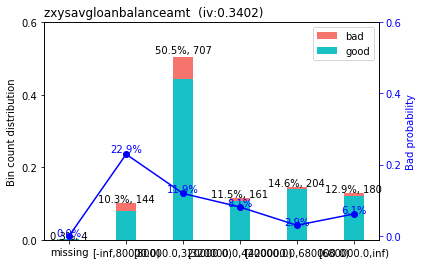

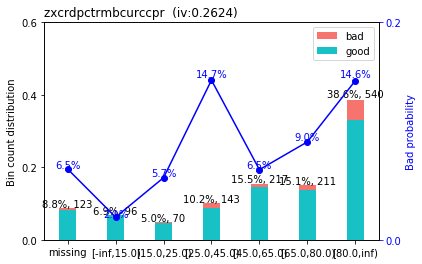

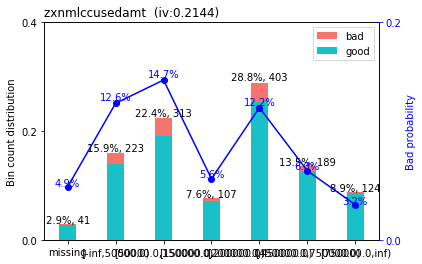

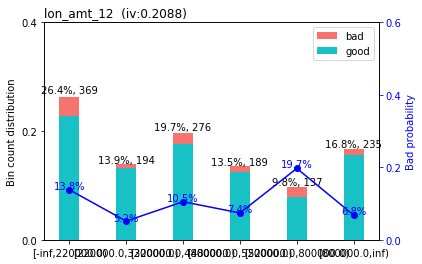

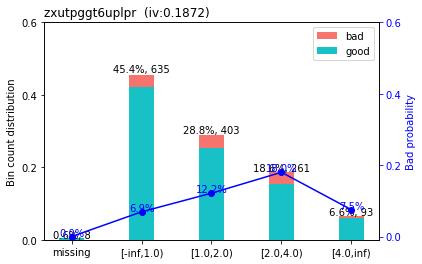

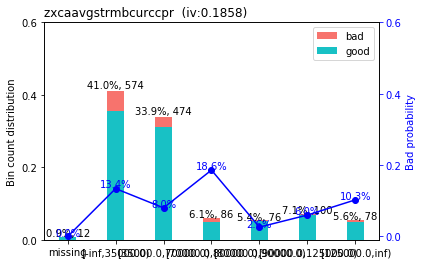

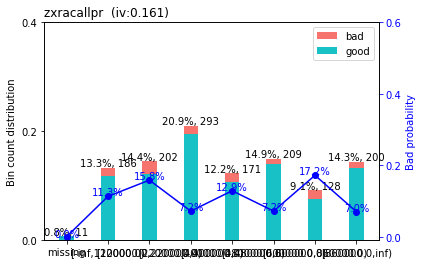

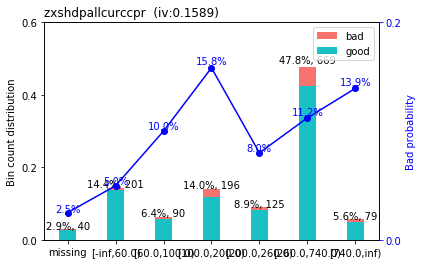

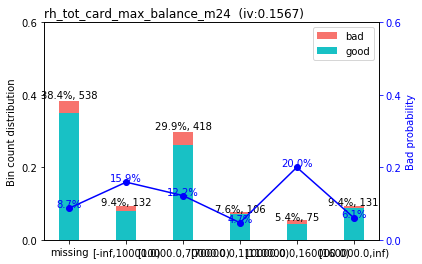

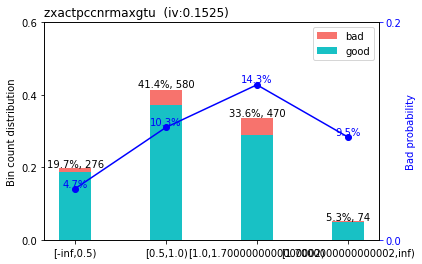

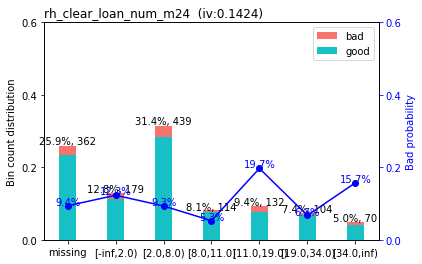

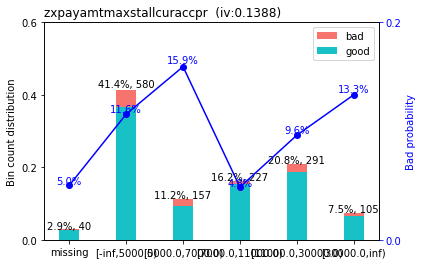

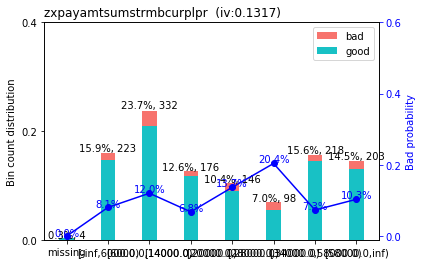

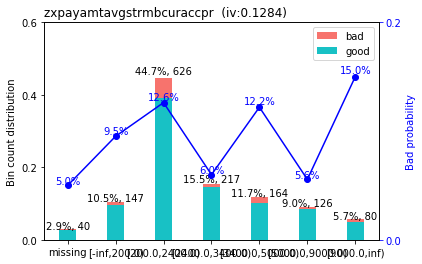

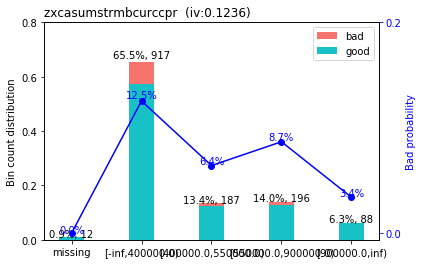

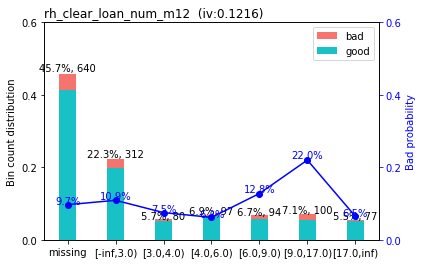

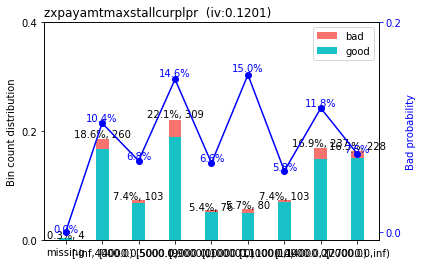

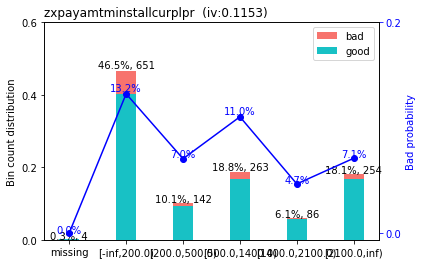

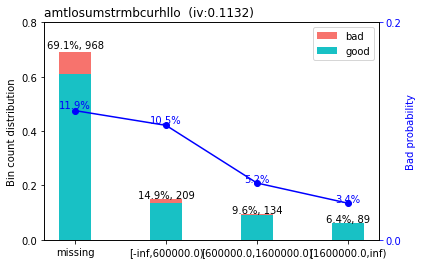

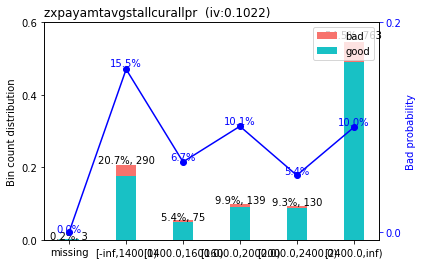

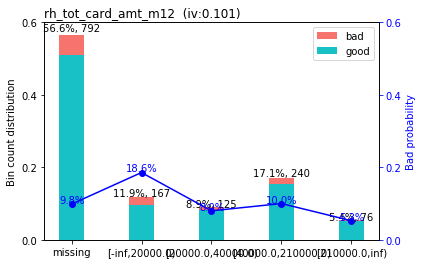

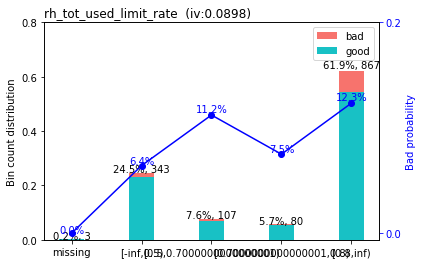

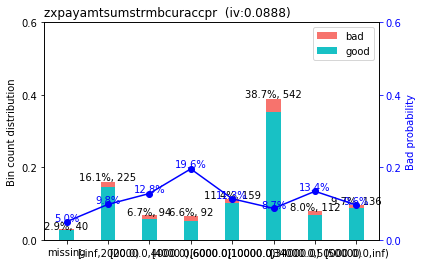

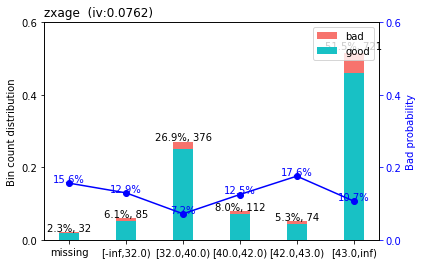

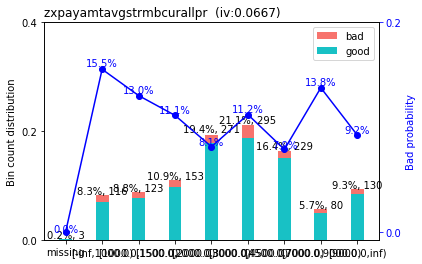

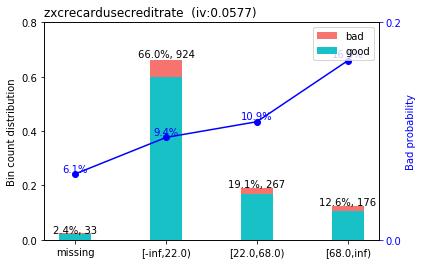

In [242]:
sc.woebin_plot(bins_dic,x=fea_info[fea_info['iv'] > 0.05].index.to_list())

In [276]:
adj_bin = sc.woebin(tra_x,x=['zxage','zxysavgloanbalanceamt','zxcrdpctrmbcurccpr','zxnmlccusedamt','lon_amt_12'],y='tag',
                    breaks_list={'zxage':[35,46],'zxysavgloanbalanceamt':[80000,220000,680000],'zxcrdpctrmbcurccpr':[15,25,80],
                                'zxnmlccusedamt':[80000,150000,450000,750000],'lon_amt_12':[200000,400000,600000]},
                   )

[INFO] creating woe binning ...


In [244]:
bins_dic['lon_amt_12']

,variable,bin,count,count_distr,good,bad,badprob,woe,bin_iv,total_iv,breaks,is_special_values
0,lon_amt_12,"[-inf,220000.0)",369,0.263571,318,51,0.138211,0.312638,2.912153e-02,0.208795,220000.0,False
1,lon_amt_12,"[220000.0,320000.0)",194,0.138571,184,10,0.051546,-0.769487,6.065126e-02,0.208795,320000.0,False
2,lon_amt_12,"[320000.0,480000.0)",276,0.197143,247,29,0.105072,0.000771,1.171834e-07,0.208795,480000.0,False
3,lon_amt_12,"[480000.0,520000.0)",189,0.135000,175,14,0.074074,-0.382865,1.700944e-02,0.208795,520000.0,False
4,lon_amt_12,"[520000.0,800000.0)",137,0.097857,110,27,0.197080,0.738220,7.078359e-02,0.208795,800000.0,False
5,lon_amt_12,"[800000.0,inf)",235,0.167857,219,16,0.068085,-0.473620,3.122905e-02,0.208795,inf,False


{'zxysavgloanbalanceamt': <Figure size 432x288 with 2 Axes>,
 'zxage': <Figure size 432x288 with 2 Axes>,
 'zxcrdpctrmbcurccpr': <Figure size 432x288 with 2 Axes>,
 'zxnmlccusedamt': <Figure size 432x288 with 2 Axes>,
 'lon_amt_12': <Figure size 432x288 with 2 Axes>}

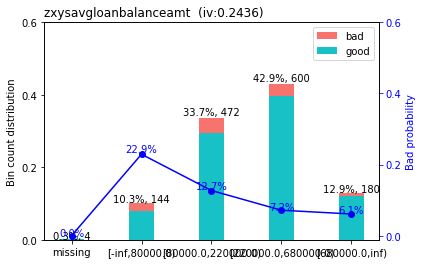

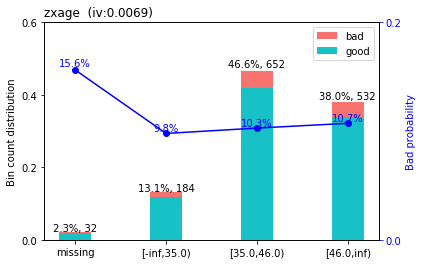

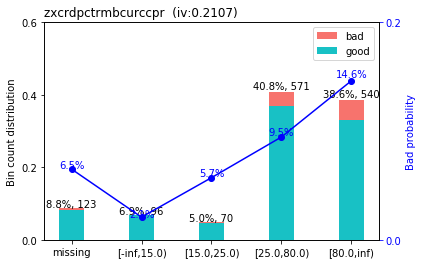

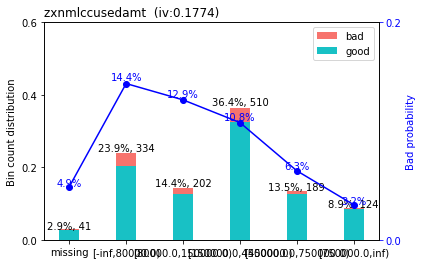

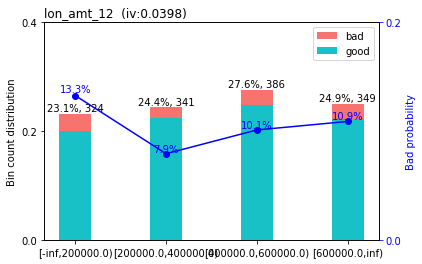

In [245]:
sc.woebin_plot(adj_bin,x=['zxysavgloanbalanceamt','zxage','zxcrdpctrmbcurccpr','zxnmlccusedamt','lon_amt_12'])

In [277]:
bins_dic.update(adj_bin)

### 3.5 剔除iv>0.05的特征

In [278]:
fea_info = FeaEdaFunc.filter_fea(bins_dic)
fea_info = fea_info.sort_values('iv',ascending=False)
fea_info[fea_info['mono_status'] == False]

,mono_status,iv
variable,,
zxcrdpctallcurccpr,False,0.268688
zxysavgloanbalanceamt,False,0.243607
sum_amt_3,False,0.220149
zxcrdpctrmbcurccpr,False,0.210679
sum_nopayoff_amt_9,False,0.207945
...,...,...
zxcamaxstusdcurccpr,False,0.009560
zxage,False,0.006943
zxcaavgstusdcuraccpr,False,0.004424


In [279]:
ivdrop_feas = fea_info[fea_info['iv'] < 0.05].index.to_list()

In [280]:
tra_x = tra_x.drop(ivdrop_feas,axis=1)
tst_x = tst_x.drop(ivdrop_feas,axis=1)
oot_x = oot_x.drop(ivdrop_feas,axis=1)

### 3.5 woe

In [281]:
tra_x_woe = sc.woebin_ply(tra_x,bins_dic)
tst_x_woe = sc.woebin_ply(tst_x,bins_dic)
oot_x_woe = sc.woebin_ply(oot_x,bins_dic)

[INFO] converting into woe values ...
[INFO] converting into woe values ...
[INFO] converting into woe values ...


### 3.6 剔除psi大于0.1的特征

In [106]:
tst_bin_group = FeaEdaFunc.bin_group(tst_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')
oot_bin_group = FeaEdaFunc.bin_group(oot_x_woe,cols=tst_x_woe.iloc[:,1:].columns,target='tag')

In [107]:
def calc_psi(train_bin_dicts,test_bin_dicts):
    """
    根据分箱后的结果计算PSI
    test_bin_dicts 为woe后的结果
    """
    psi_dict = {}
    for k,te in test_bin_dicts.items():
        if 'woe' in k:
            k = k.split('_woe')[0]
            te = te.rename({'%s_woe' % k:k},axis=1).set_index(k)
            tr = train_bin_dicts[k].rename({'woe':k},axis=1).set_index(k)
        else:
            te = te.set_index(k)
            tr = train_bin_dicts[k].set_index(k)
        pair = pd.concat([te['count_distr'],tr['count_distr']],axis=1,keys=['test','train'])
        psi = sum(((pair['test']-pair['train'])*(np.log(pair['test']/pair['train']))).dropna())
        psi_dict[k] = psi
    return psi_dict

In [108]:
psi_info1 = calc_psi(bins_dic,tst_bin_group)
psi_info2 = calc_psi(bins_dic,oot_bin_group)

In [109]:
psi_df1 = pd.DataFrame(psi_info1,index=['psi']).T.sort_values('psi',ascending=False)
psi_df2 = pd.DataFrame(psi_info2,index=['psi']).T.sort_values('psi',ascending=False)

In [110]:
psi_drop1 = set(psi_df1[psi_df1['psi']>0.1].index)
psi_drop2 = set(psi_df2[psi_df2['psi']>0.1].index)
psi_drop = psi_drop1 | psi_drop2

In [111]:
psi_drop = [i+'_woe' for i in psi_drop]

In [112]:
psi_drop

['zxcrecardusecreditrate_woe', 'amtlosumstrmbcurhllo_woe']

### 3.7 共线性剔除 

In [60]:
tra_x_woe.corr().style.background_gradient()

,tag,zxysavgloanbalanceamt_woe,zxutpggt6uplpr_woe,zxcaavgstrmbcurccpr_woe,amtlosumstrmbcurhllo_woe,zxpayamtavgstallcurallpr_woe,zxshdpallcurccpr_woe,zxpayamtmaxstallcuraccpr_woe,zxcasumstrmbcurccpr_woe,zxpayamtsumstrmbcurplpr_woe,zxcrdpctrmbcurccpr_woe,zxnmlccusedamt_woe,lon_amt_12_woe,zxactpccnrmaxgtu_woe,rh_tot_card_max_balance_m24_woe,rh_clear_loan_num_m24_woe,zxpayamtmaxstallcurplpr_woe,zxpayamtminstallcurplpr_woe,rh_tot_card_amt_m12_woe,zxpayamtavgstrmbcuraccpr_woe,rh_clear_loan_num_m12_woe,zxracallpr_woe
tag,1.000000,0.163053,0.136128,0.121262,0.087112,0.091071,0.108350,0.104546,0.096770,0.112179,0.135956,0.125429,0.139116,0.108868,0.119497,0.118665,0.100380,0.094297,0.101566,0.101819,0.114296,0.126309
zxysavgloanbalanceamt_woe,0.163053,1.000000,0.221442,0.235035,0.223914,0.130609,0.021457,0.035610,0.217900,-0.016085,0.079619,0.211852,0.200624,0.068909,0.082407,-0.015455,0.121673,0.218886,0.063224,0.060568,0.013798,0.188502
zxutpggt6uplpr_woe,0.136128,0.221442,1.000000,0.058719,0.028936,-0.099400,0.120981,-0.006255,0.074344,0.062961,0.110440,0.041173,0.063340,0.128536,0.100601,0.000460,0.052245,0.051904,0.037954,-0.017405,-0.004280,0.070270
zxcaavgstrmbcurccpr_woe,0.121262,0.235035,0.058719,1.000000,0.128211,0.099181,-0.057430,0.073000,0.333551,0.024300,0.039649,0.215754,0.102534,-0.099567,0.082867,-0.021788,0.103325,0.032505,0.141294,0.056773,0.031776,0.065044
amtlosumstrmbcurhllo_woe,0.087112,0.223914,0.028936,0.128211,1.000000,0.020417,-0.010275,-0.000044,0.160179,0.007310,0.022078,0.114766,0.030597,-0.008346,0.047908,-0.000385,0.081358,0.010818,0.082107,-0.018902,0.010464,0.049240
zxpayamtavgstallcurallpr_woe,0.091071,0.130609,-0.099400,0.099181,0.020417,1.000000,-0.058756,0.132846,0.076287,-0.084121,-0.055134,0.053088,0.037393,-0.082437,0.040819,0.013098,-0.028416,0.064539,0.048067,0.078265,0.030907,0.037821
zxshdpallcurccpr_woe,0.108350,0.021457,0.120981,-0.057430,-0.010275,-0.058756,1.000000,0.103207,-0.115567,0.011674,0.486356,0.110732,0.013281,0.678029,0.032488,0.019422,-0.008805,0.020520,-0.031635,0.166884,0.021233,0.040495
zxpayamtmaxstallcuraccpr_woe,0.104546,0.035610,-0.006255,0.073000,-0.000044,0.132846,0.103207,1.000000,0.060834,0.015313,0.052674,0.128513,-0.018648,0.041215,-0.008553,0.034899,-0.013836,0.036290,-0.036234,0.263362,0.048970,-0.003106
zxcasumstrmbcurccpr_woe,0.096770,0.217900,0.074344,0.333551,0.160179,0.076287,-0.115567,0.060834,1.000000,0.023450,0.043172,0.494957,0.069390,-0.170275,0.072879,-0.033710,0.083760,0.028490,0.171467,0.071453,0.037994,0.069296
zxpayamtsumstrmbcurplpr_woe,0.112179,-0.016085,0.062961,0.024300,0.007310,-0.084121,0.011674,0.015313,0.023450,1.000000,-0.008316,-0.002668,-0.023069,0.003693,-0.007714,-0.022625,0.029045,-0.023733,-0.035656,0.018749,0.033956,-0.008045


In [113]:
tst_x_woe = tst_x_woe.drop(psi_drop,axis=1)
tra_x_woe = tra_x_woe.drop(psi_drop,axis=1)
oot_x_woe = oot_x_woe.drop(psi_drop,axis=1)

In [282]:
tra_x_woe = tra_x_woe.drop('tag',axis=1).reset_index(drop=True)
tst_x_woe = tst_x_woe.drop('tag',axis=1).reset_index(drop=True)
oot_y = oot_x_woe['tag'].reset_index(drop=True)
oot_x_woe = oot_x_woe.drop('tag',axis=1).reset_index(drop=True)

## 3.初步测试

In [104]:
def val_clf(x,y,oot_x,oot_y,score,clf=LGBMClassifier(),pert_func=sc.perf_eva):
    tra_x,tst_x,tra_y,tst_y = train_test_split(x,y,test_size=0.3,shuffle=True)
    clf.fit(tra_x,tra_y)
    pred_y = clf.predict_proba(tst_x)[:,1]
    oot_pred_y = clf.predict_proba(oot_x)[:,1]
    if pert_func:
        pert_func(tst_y,pred_y)
        pert_func(oot_y,oot_pred_y)
    else:
        print(score(tst_y,pred_y))

In [283]:
tst_x_woe = tst_x_woe.apply(lambda x:x.fillna(x.median()))
oot_x_woe = oot_x_woe.apply(lambda x:x.fillna(x.median()))

In [284]:
tra_x_woe.shape

(1400, 67)

In [285]:
clf = LogisticRegression(class_weight='balanced')
clf.fit(tra_x_woe,tra_y)
tra_pred_y = clf.predict_proba(tra_x_woe)[:,1]
tst_pred_y = clf.predict_proba(tst_x_woe)[:,1]
oot_pred_y = clf.predict_proba(oot_x_woe)[:,1]

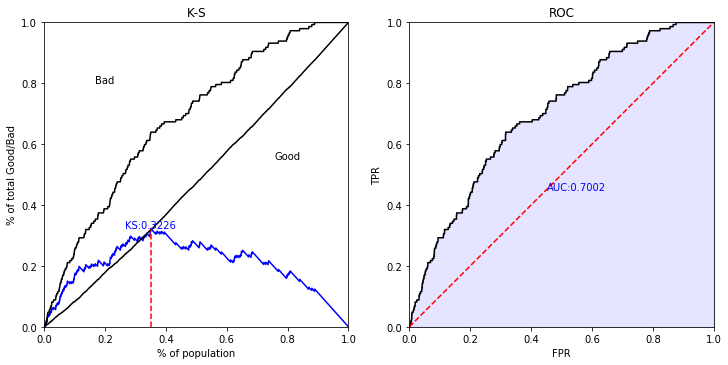

{'KS': 0.3226,
 'AUC': 0.7002,
 'Gini': 0.4005,
 'pic': <Figure size 864x432 with 2 Axes>}

In [286]:
sc.perf_eva(tra_y,tra_pred_y)  

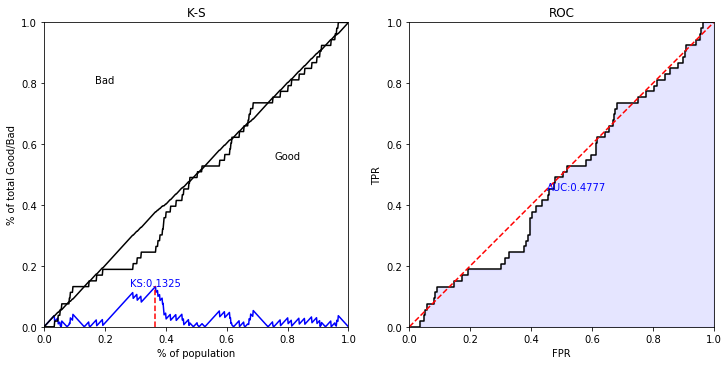

{'KS': 0.1325,
 'AUC': 0.4777,
 'Gini': -0.0446,
 'pic': <Figure size 864x432 with 2 Axes>}

In [287]:
sc.perf_eva(tst_y,tst_pred_y)                                                                                                                                   

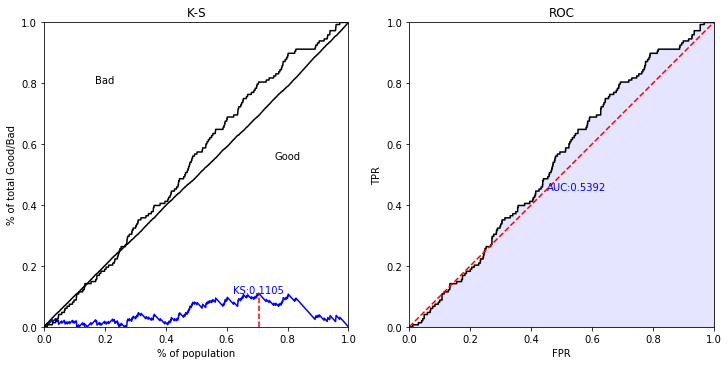

{'KS': 0.1105,
 'AUC': 0.5392,
 'Gini': 0.0785,
 'pic': <Figure size 864x432 with 2 Axes>}

In [288]:
sc.perf_eva(oot_y,oot_pred_y)  

In [586]:
m=13
r=1.5
h=1.4
sr=0.86
m*0.9-r+h

11.600000000000001